In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers, callbacks, regularizers
import cv2
from glob import glob
import matplotlib.pyplot as plt

# Enable GPU usage
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 1


In [2]:
# Function to apply sharpening
def sharpen_image(img):
    kernel = np.array([[0, -1, 0], [-1, 5,-1], [0, -1, 0]])
    return cv2.filter2D(img, -1, kernel)

# Function to apply Gaussian Blur
def gaussian_blur(img):
    return cv2.GaussianBlur(img, (5, 5), 0)

# Custom preprocessing function
def preprocess_image(img):
    img = cv2.resize(img, (128, 128))
    img = sharpen_image(img)
    img = gaussian_blur(img)
    img = img / 255.0
    return img

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    preprocessing_function=preprocess_image
)

valid_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=preprocess_image)
test_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=preprocess_image)

train_dir = "/kaggle/input/dataset/train"
valid_dir = "/kaggle/input/dataset/val"
test_dir = "/kaggle/input/dataset/test"

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(128, 128), batch_size=64, class_mode='binary')
valid_generator = valid_datagen.flow_from_directory(valid_dir, target_size=(128, 128), batch_size=64, class_mode='binary')
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(128, 128), batch_size=64, class_mode='binary')

Found 4946 images belonging to 2 classes.
Found 120 images belonging to 2 classes.
Found 126 images belonging to 2 classes.


In [3]:
def build_model():
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(128, 128, 3)),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),

        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),

        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),

        layers.Conv2D(256, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2,2),

        layers.Flatten(),
        layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.Dropout(0.5),

        layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.Dropout(0.5),

        layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

model = build_model()
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       8,389,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,911,041 (33.99 MB)

 Trainable params: 8,910,081 (33.99 MB)

 Non-trainable params: 960 (3.75 KB)

In [4]:
# Early stopping to prevent overfitting
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Reduce learning rate when validation loss plateaus
lr_reduction = callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, verbose=1)

# Model checkpoint to save the best model
checkpoint = callbacks.ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

callbacks_list = [early_stopping, lr_reduction, checkpoint]

In [5]:
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=50,
    batch_size=64,
    callbacks=callbacks_list
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


78/78 ━━━━━━━━━━━━━━━━━━━━ 158s 2s/step - accuracy: 0.5857 - loss: 2.4052 - val_accuracy: 0.7667 - val_loss: 1.9746 - learning_rate: 1.0000e-04
Epoch 2/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 75s 884ms/step - accuracy: 0.6647 - loss: 2.0039 - val_accuracy: 0.2333 - val_loss: 2.0175 - learning_rate: 1.0000e-04
Epoch 3/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 76s 886ms/step - accuracy: 0.6954 - loss: 1.8967 - val_accuracy: 0.7667 - val_loss: 1.9539 - learning_rate: 1.0000e-04
Epoch 4/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 75s 887ms/step - accuracy: 0.7267 - loss: 1.8152 - val_accuracy: 0.7667 - val_loss: 1.8228 - learning_rate: 1.0000e-04
Epoch 5/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 74s 875ms/step - accuracy: 0.7500 - loss: 1.7557 - val_accuracy: 0.7667 - val_loss: 1.7896 - learning_rate: 1.0000e-04
Epoch 6/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 74s 862ms/step - accuracy: 0.7740 - loss: 1.6936 - val_accuracy: 0.7333 - val_loss: 1.8217 - learning_rate: 1.0000e-04
Epoch 7/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 73s 859ms/step - accuracy: 0.7878

In [6]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

model.save("oral_cancer_classifier.keras")

2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 4s/step - accuracy: 0.7474 - loss: 1.8033
Test Accuracy: 75.40%


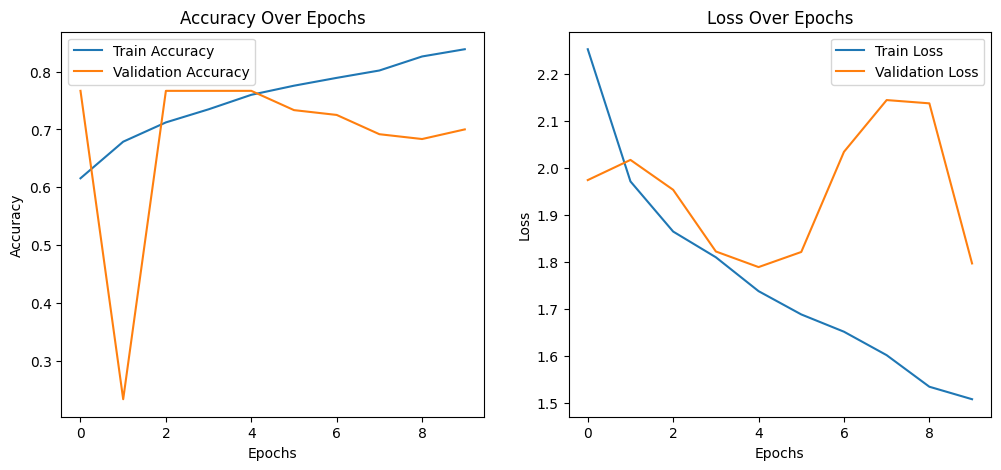

In [7]:
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step


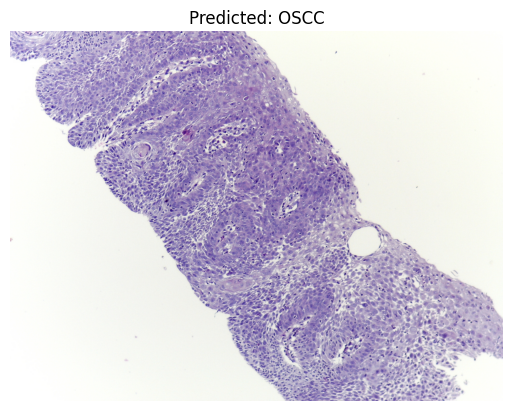

In [8]:
import random

# Get a random test image
test_images = glob(test_dir + "/*/*")
random_image = random.choice(test_images)

# Load and preprocess image
img = cv2.imread(random_image)
img = cv2.resize(img, (128, 128))
img = img / 255.0
img = np.expand_dims(img, axis=0)

# Predict
prediction = model.predict(img)
class_label = "OSCC" if prediction[0][0] > 0.5 else "Normal"

# Show the image
plt.imshow(cv2.cvtColor(cv2.imread(random_image), cv2.COLOR_BGR2RGB))
plt.title(f"Predicted: {class_label}")
plt.axis("off")
plt.show()